# Tensorflow2 KeyNotes
### ==== Time Series Forechasting with Neural Networks (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate the time series forecasting by using variant neural network architectures, the results derived from different neural networks are quantitatively compared. The following contents are included in this notebook:

1. Time series forecasting by using a dense neural network.
2. Time series forecasting by using a simple recurrent neural network.
3. Time series forecasting by using a deep recurrent neural network. 
4. Time series forecasting by using a deep convolutional neural network.

### Code by Hao, Zhao, Aug, 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack
import time

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D,SimpleRNN,AveragePooling1D,Flatten


### Generate a synthetic time series based on sinusoid signals



In [3]:
dt,t_min,t_max = 0.001,0,20 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1,f2       = 30,100,200
SNR            = 20       
syn_sig        = np.sin((2*np.pi*f0)*t)  + np.sin((2*np.pi*f1)*t) + np.sin((2*np.pi*f2)*t)  
syn_data       = syn_sig + np.random.normal(0,10**(-SNR/20),len(syn_sig))


### Plot the generated time series

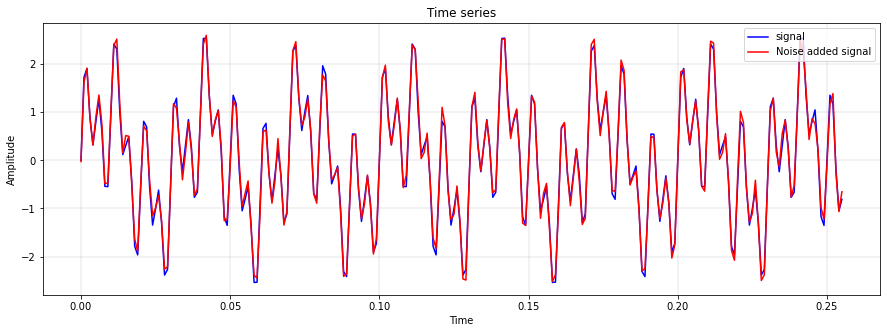

In [4]:

#set the samples to display
N=256

plt.figure(0,figsize=(15, 5))
plt.plot(t[0:N],syn_sig[0:N],'b',label='signal')
plt.plot(t[0:N],syn_data[0:N],'r',label='Noise added signal') 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Dataset preprocessing to generate the training and testing datasets

In [5]:

# define the function for datasets generation 

def dataset_generation(time_series,batch_size,window_step,predict_step):
    
    # derive the total batch numbers
    n_batch = ((len(t))-batch_size)//window_step + 1
    
    # derive the datasets: input (x) and tartget (y)
    dataset_x     = []
    dataset_y     = []    
    train_set_x   = []
    train_set_y   = []
    test_set_x    = []
    test_set_y    = []
    
    # loop through the time series and gernerate the data
    for n in np.arange(1,n_batch+1):
        
        data_batch = time_series[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        data_x     = data_batch[0:batch_size-predict_step]
        data_y     = data_batch[batch_size-predict_step:batch_size]
    
        dataset_x  = np.concatenate((dataset_x, data_x))
        dataset_y  = np.concatenate((dataset_y, data_y))
        
    # reshape datasets to 2d dimension: batch x dataset
    dataset_x = np.reshape(dataset_x, newshape=(n_batch,len(data_x)))
    dataset_y = np.reshape(dataset_y, newshape=(n_batch,len(data_y)))
    
    # split the dataset into train 80% and test sets (20%)
    train_samples  = int(len(dataset_x) * 0.8) 

    train_set_x = dataset_x[:train_samples,:]
    train_set_y = dataset_y[:train_samples,:]

    test_set_x  = dataset_x[train_samples:,:]
    test_set_y  = dataset_y[train_samples:,:] 
        
    return train_set_x,train_set_y,test_set_x,test_set_y
    

# generate the datasets 
batch_size   = 256
window_step  = batch_size//8
predict_step = 10

train_set_x,train_set_y,test_set_x,test_set_y = dataset_generation(syn_data,batch_size,window_step,predict_step)

print('train_set_x: has shape {}'.format(train_set_x.shape))
print('train_set_y: has shape {}'.format(train_set_y.shape))
print('test_set_x: has shape {}'.format(test_set_x.shape))
print('test_set_y: has shape {}'.format(test_set_y.shape))



train_set_x: has shape (494, 246)
train_set_y: has shape (494, 10)
test_set_x: has shape (124, 246)
test_set_y: has shape (124, 10)


----------------------------------------------------------------------
## Method-1: Dense neural network 
----------------------------------------------------------------------


 ### Build the neural network 

In [6]:
model = Sequential([Dense(32, activation='relu',input_shape=(batch_size-predict_step,)),
                    Dropout(0.1),
                    Dense(16,activation='relu'),
                    Dropout(0.1),
                    Dense(predict_step)
                    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                7904      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 8,602
Trainable params: 8,602
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [7]:
start      = time.time()
history    = model.fit(train_set_x,train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Epoch 1/100
14/14 [==============================] - 0s 9ms/step - loss: 1.2873 - mae: 0.9132 - val_loss: 0.7553 - val_mae: 0.7042
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8441 - mae: 0.7377 - val_loss: 0.5570 - val_mae: 0.6086
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6881 - mae: 0.6640 - val_loss: 0.4189 - val_mae: 0.5308
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6201 - mae: 0.6219 - val_loss: 0.3367 - val_mae: 0.4670
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5548 - mae: 0.5854 - val_loss: 0.2759 - val_mae: 0.4239
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5145 - mae: 0.5547 - val_loss: 0.2426 - val_mae: 0.3909
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4663 - mae: 0.5294 - val_loss: 0.2009 - val_mae: 0.3591
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4364 - m

14/14 [==============================] - 0s 3ms/step - loss: 0.1605 - mae: 0.2950 - val_loss: 0.0410 - val_mae: 0.1600
Epoch 64/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1609 - mae: 0.2881 - val_loss: 0.0468 - val_mae: 0.1682
Epoch 65/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1638 - mae: 0.2908 - val_loss: 0.0288 - val_mae: 0.1383
Epoch 66/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1598 - mae: 0.2913 - val_loss: 0.0383 - val_mae: 0.1559
Epoch 67/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1623 - mae: 0.2889 - val_loss: 0.0397 - val_mae: 0.1611
Epoch 68/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1617 - mae: 0.2905 - val_loss: 0.0407 - val_mae: 0.1590
Epoch 69/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1770 - mae: 0.3039 - val_loss: 0.0358 - val_mae: 0.1537
Epoch 70/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1601 - mae: 0

### Display of training and validation losses in the network training


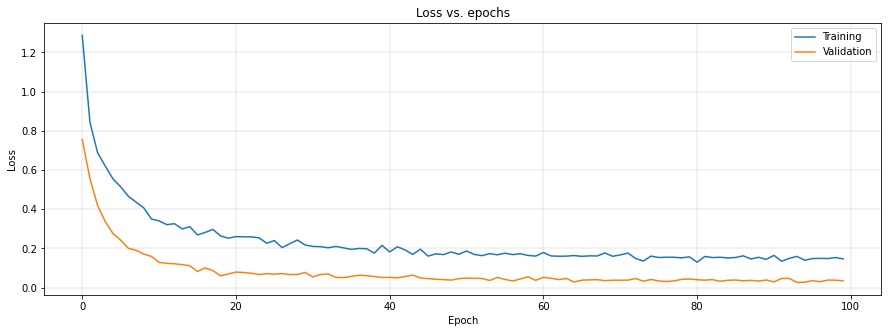

In [8]:
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned dense neural network


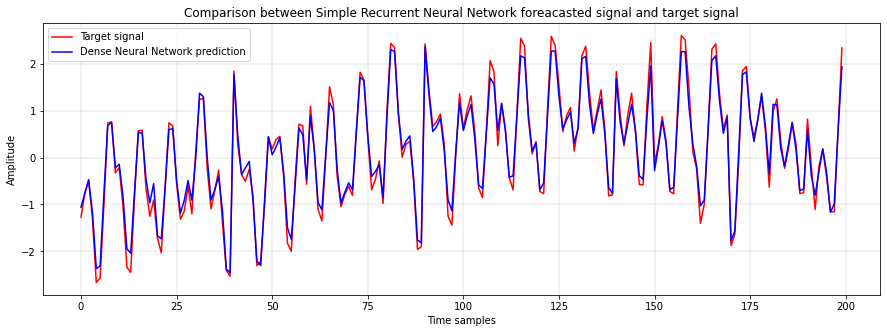

Neural network SNR: 16.75424564223896
Mean Square Error: 0.03208590703257732


In [9]:
dnn_predictions = model.predict(test_set_x)
dnn_err         = dnn_predictions - test_set_y

plt.figure(3,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(dnn_predictions[:20,:].flatten(),'b',label='Dense Neural Network prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Simple Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

dnn_mse    = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Neural network SNR:", dnn_sigpow - dnn_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)))



----------------------------------------------------------------------
## Method-2: Simple recurrent neural network 
----------------------------------------------------------------------


 ### Build a simple recurrent neural network

In [10]:
model_simple_rnn = Sequential([SimpleRNN(predict_step,input_shape=[batch_size-predict_step,1])])

model_simple_rnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model_simple_rnn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [11]:
start      = time.time()
history    = model_simple_rnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Epoch 1/100
14/14 [==============================] - 1s 84ms/step - loss: 1.8373 - mae: 1.0848 - val_loss: 1.7947 - val_mae: 1.0749
Epoch 2/100
14/14 [==============================] - 1s 79ms/step - loss: 1.7302 - mae: 1.0547 - val_loss: 1.7095 - val_mae: 1.0521
Epoch 3/100
14/14 [==============================] - 1s 83ms/step - loss: 1.6539 - mae: 1.0328 - val_loss: 1.6392 - val_mae: 1.0321
Epoch 4/100
14/14 [==============================] - 1s 83ms/step - loss: 1.5900 - mae: 1.0139 - val_loss: 1.5787 - val_mae: 1.0152
Epoch 5/100
14/14 [==============================] - 1s 78ms/step - loss: 1.5361 - mae: 0.9980 - val_loss: 1.5281 - val_mae: 1.0016
Epoch 6/100
14/14 [==============================] - 1s 81ms/step - loss: 1.4901 - mae: 0.9852 - val_loss: 1.4835 - val_mae: 0.9891
Epoch 7/100
14/14 [==============================] - 1s 82ms/step - loss: 1.4480 - mae: 0.9730 - val_loss: 1.4417 - val_mae: 0.9766
Epoch 8/100
14/14 [==============================] - 1s 84ms/step - loss: 1.

14/14 [==============================] - 1s 79ms/step - loss: 0.6646 - mae: 0.6413 - val_loss: 0.6684 - val_mae: 0.6497
Epoch 63/100
14/14 [==============================] - 1s 79ms/step - loss: 0.6632 - mae: 0.6407 - val_loss: 0.6680 - val_mae: 0.6483
Epoch 64/100
14/14 [==============================] - 1s 79ms/step - loss: 0.6585 - mae: 0.6375 - val_loss: 0.6654 - val_mae: 0.6487
Epoch 65/100
14/14 [==============================] - 1s 80ms/step - loss: 0.6590 - mae: 0.6370 - val_loss: 0.6642 - val_mae: 0.6490
Epoch 66/100
14/14 [==============================] - 1s 79ms/step - loss: 0.6541 - mae: 0.6351 - val_loss: 0.6616 - val_mae: 0.6442
Epoch 67/100
14/14 [==============================] - 1s 81ms/step - loss: 0.6542 - mae: 0.6343 - val_loss: 0.6585 - val_mae: 0.6452
Epoch 68/100
14/14 [==============================] - 1s 80ms/step - loss: 0.6525 - mae: 0.6333 - val_loss: 0.6589 - val_mae: 0.6448
Epoch 69/100
14/14 [==============================] - 1s 81ms/step - loss: 0.6479 

### Display of training and validation losses in the network training

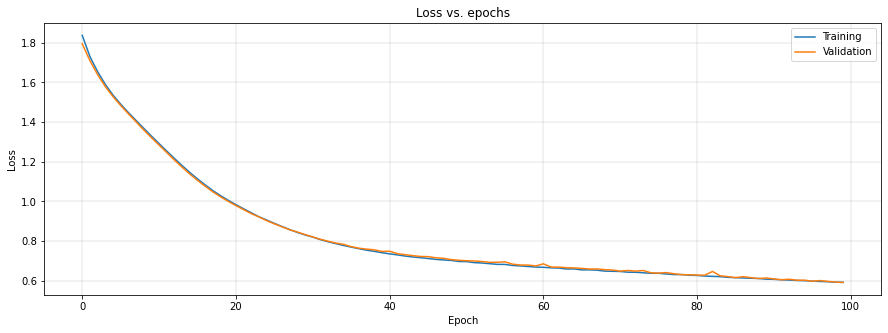

In [12]:
plt.figure(4,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned neural network

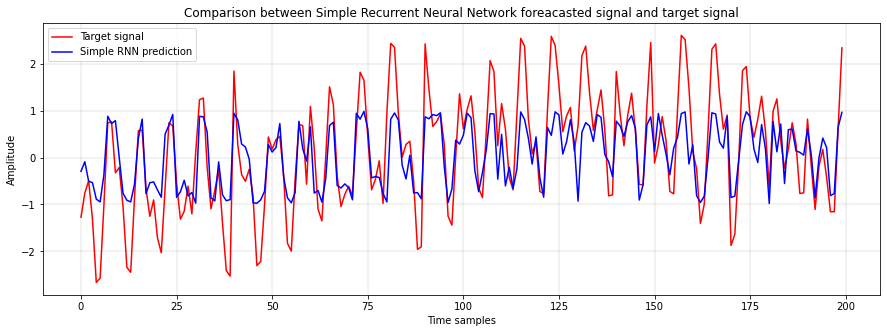

Simple Recurrent Neural network's SNR: 4.076861059255048
Mean Square Error: 0.5943643863838288


In [13]:
simple_RNN_predictions = model_simple_rnn.predict(test_set_x[...,np.newaxis])
simple_RNN_err         = simple_RNN_predictions - test_set_y

plt.figure(5,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(simple_RNN_predictions[:20,:].flatten(),'b',label='Simple RNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Simple Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

simple_RNN_mse    = 10*np.log10(np.mean(pow(np.abs(simple_RNN_err),2)))
simple_RNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Simple Recurrent Neural network's SNR:", simple_RNN_sigpow - simple_RNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(simple_RNN_predictions,test_set_y)))

----------------------------------------------------------------------
## Method-3: Deep recurrent neural network 
----------------------------------------------------------------------


 ### Build a Deep recurrent neural network

In [14]:
model_deep_rnn = Sequential([SimpleRNN(20,input_shape=[batch_size-predict_step,1],return_sequences=True),
                             # SimpleRNN(20,return_sequences=True),
                             # SimpleRNN(predict_step),
                             SimpleRNN(20,return_sequences=False),
                             Dense(predict_step)
                             ])

model_deep_rnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])
model_deep_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 246, 20)           440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [15]:
start      = time.time()
history    = model_deep_rnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Epoch 1/100
14/14 [==============================] - 2s 171ms/step - loss: 1.4623 - mae: 0.9819 - val_loss: 1.2603 - val_mae: 0.9180
Epoch 2/100
14/14 [==============================] - 2s 158ms/step - loss: 1.1478 - mae: 0.8744 - val_loss: 1.0357 - val_mae: 0.8329
Epoch 3/100
14/14 [==============================] - 2s 158ms/step - loss: 0.9429 - mae: 0.7910 - val_loss: 0.8414 - val_mae: 0.7505
Epoch 4/100
14/14 [==============================] - 2s 157ms/step - loss: 0.7587 - mae: 0.7075 - val_loss: 0.6738 - val_mae: 0.6743
Epoch 5/100
14/14 [==============================] - 2s 156ms/step - loss: 0.6003 - mae: 0.6276 - val_loss: 0.5319 - val_mae: 0.5962
Epoch 6/100
14/14 [==============================] - 2s 157ms/step - loss: 0.4681 - mae: 0.5525 - val_loss: 0.4121 - val_mae: 0.5215
Epoch 7/100
14/14 [==============================] - 2s 157ms/step - loss: 0.3633 - mae: 0.4829 - val_loss: 0.3184 - val_mae: 0.4588
Epoch 8/100
14/14 [==============================] - 2s 160ms/step - 

14/14 [==============================] - 2s 158ms/step - loss: 0.0155 - mae: 0.0996 - val_loss: 0.0191 - val_mae: 0.1116
Epoch 63/100
14/14 [==============================] - 2s 157ms/step - loss: 0.0169 - mae: 0.1038 - val_loss: 0.0167 - val_mae: 0.1050
Epoch 64/100
14/14 [==============================] - 2s 158ms/step - loss: 0.0160 - mae: 0.1011 - val_loss: 0.0161 - val_mae: 0.1020
Epoch 65/100
14/14 [==============================] - 2s 160ms/step - loss: 0.0148 - mae: 0.0974 - val_loss: 0.0160 - val_mae: 0.1025
Epoch 66/100
14/14 [==============================] - 2s 159ms/step - loss: 0.0165 - mae: 0.1019 - val_loss: 0.0172 - val_mae: 0.1066
Epoch 67/100
14/14 [==============================] - 2s 158ms/step - loss: 0.0151 - mae: 0.0987 - val_loss: 0.0151 - val_mae: 0.1002
Epoch 68/100
14/14 [==============================] - 2s 159ms/step - loss: 0.0163 - mae: 0.1017 - val_loss: 0.0153 - val_mae: 0.0993
Epoch 69/100
14/14 [==============================] - 2s 157ms/step - loss:

### Display of training and validation losses in the network training

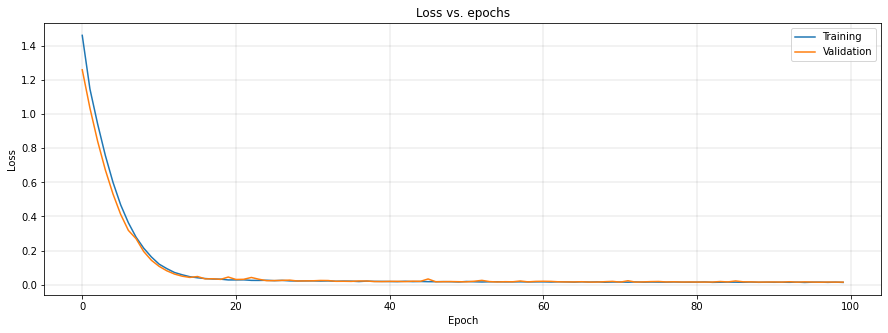

In [16]:
plt.figure(6,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Time series forecasting with trainned neural network

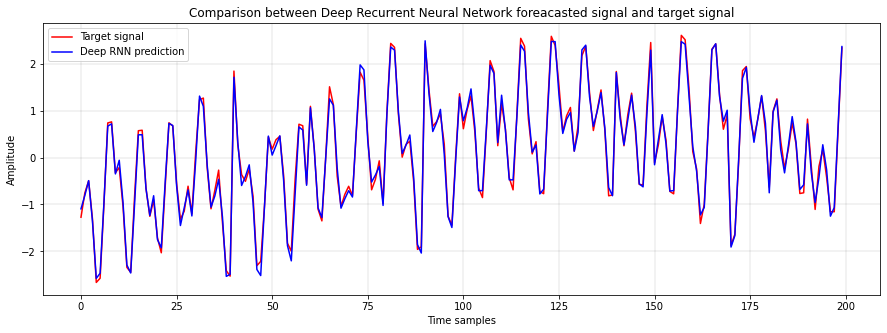

Deep Recurrent Neural network's SNR: 20.41627511465968
Mean Square Error: 0.013807383055890207


In [17]:
deep_RNN_predictions = model_deep_rnn.predict(test_set_x[...,np.newaxis])
deep_RNN_err         = deep_RNN_predictions - test_set_y

plt.figure(7,figsize=(15, 5))

plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(deep_RNN_predictions[:20,:].flatten(),'b',label='Deep RNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Deep Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

deep_RNN_mse    = 10*np.log10(np.mean(pow(np.abs(deep_RNN_err),2)))
deep_RNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Deep Recurrent Neural network's SNR:", deep_RNN_sigpow - deep_RNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(deep_RNN_predictions,test_set_y)))


----------------------------------------------------------------------
## Method-4: Deep convolutional neural network 
----------------------------------------------------------------------


 ### Build a Deep convolutional neural network

In [18]:
model_deep_cnn = Sequential([Conv1D(filters=5, kernel_size=4, activation='tanh',input_shape=[batch_size-predict_step,1]),
                             AveragePooling1D(pool_size=4),
                             Flatten(),
                             Dense(16, activation='relu'),
                             Dense(predict_step)
                             ])

model_deep_cnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])
model_deep_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 243, 5)            25        
_________________________________________________________________
average_pooling1d (AveragePo (None, 60, 5)             0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 5,011
Trainable params: 5,011
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [19]:
start      = time.time()
history    = model_deep_cnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Epoch 1/100
14/14 [==============================] - 0s 10ms/step - loss: 1.2265 - mae: 0.9071 - val_loss: 1.0184 - val_mae: 0.8279
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8692 - mae: 0.7613 - val_loss: 0.7427 - val_mae: 0.7024
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6385 - mae: 0.6484 - val_loss: 0.5546 - val_mae: 0.6031
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4812 - mae: 0.5639 - val_loss: 0.4211 - val_mae: 0.5248
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3648 - mae: 0.4874 - val_loss: 0.3158 - val_mae: 0.4511
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2669 - mae: 0.4113 - val_loss: 0.2240 - val_mae: 0.3732
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1854 - mae: 0.3368 - val_loss: 0.1536 - val_mae: 0.3054
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1264 - 

Epoch 63/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0122 - mae: 0.0884 - val_loss: 0.0131 - val_mae: 0.0919
Epoch 64/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0879 - val_loss: 0.0136 - val_mae: 0.0951
Epoch 65/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0879 - val_loss: 0.0132 - val_mae: 0.0937
Epoch 66/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0872 - val_loss: 0.0143 - val_mae: 0.0975
Epoch 67/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0871 - val_loss: 0.0149 - val_mae: 0.0972
Epoch 68/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0889 - val_loss: 0.0128 - val_mae: 0.0917
Epoch 69/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0860 - val_loss: 0.0137 - val_mae: 0.0943
Epoch 70/100
14/14 [==============================] - 0s 3ms/step - loss: 0.

### Display of training and validation losses in the network training

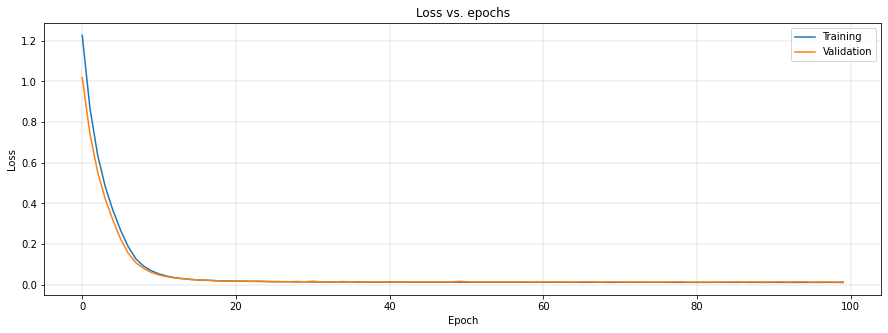

In [20]:
plt.figure(8,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned neural network

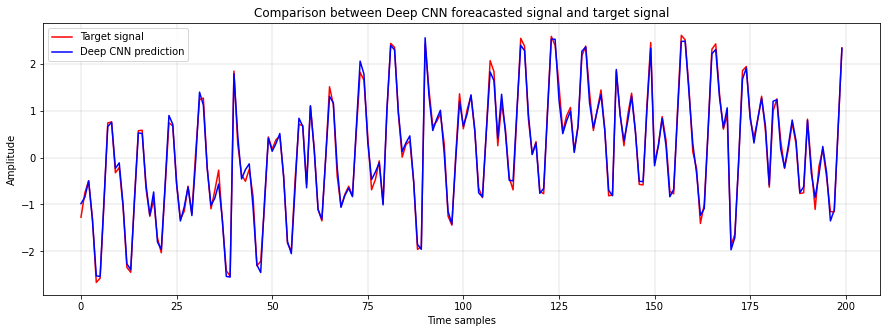

Deep Recurrent Neural network's SNR: 20.589377919105868
Mean Square Error: 0.013267866502797585


In [21]:
deep_CNN_predictions = model_deep_cnn.predict(test_set_x[...,np.newaxis])
deep_CNN_err         = deep_CNN_predictions - test_set_y

plt.figure(9,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(deep_CNN_predictions[:20,:].flatten(),'b',label='Deep CNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Deep CNN foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

deep_CNN_mse    = 10*np.log10(np.mean(pow(np.abs(deep_CNN_err),2)))
deep_CNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Deep Recurrent Neural network's SNR:", deep_CNN_sigpow - deep_CNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(deep_CNN_predictions,test_set_y)))